# Init

In [2]:
try:
    import os
    import glob
    import sys
    import math
    from typing import List, Optional
    from functools import partial
    import itertools
    import copy
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")

In [3]:
sys.path.append(os.environ['DEV_AUTOTS'])
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
folder = os.environ['CAPSTONE_DATA']

In [4]:
try:
    # Data Tables
    import pandas as pd
    import numpy as np

    # Plotting
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.offline as py
    from plotly.offline import plot
    py.init_notebook_mode(connected=True)

    # EDA and Feature Engineering
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from scipy import signal
    from scipy.spatial.distance import euclidean, pdist, squareform
    import statsmodels.api as sm

    # Auto Time Series
    import auto_ts as AT

    # Optimizer
    from skopt import gp_minimize
    from skopt.space import Real, Integer
    from skopt.plots import plot_convergence
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")

Running Auto Timeseries version: 0.0.24


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
try:
    from ETL.ETL import loadDataset, getTopProducts
    from similarity.similarity import mergeTopSimilar, loadSimilarity
    from charting.charting import surface3DChart
except Exception as e:
    print(e)
    print("Some of the libraries needed to run this script were not installed or were not loaded. Please install the libraries before proceeding.")    

In [7]:
dataRaw= loadDataset(version=4)
dfSimilarity = loadSimilarity(version=4)

# Prep Data

In [8]:
#Parameters
ChainMaster = 'SPECS'
ProdCat='SUP PREM WHISKEY'
TOP_PRODUCTS = 3  # How many products to consider in the category
TOP_SIMILAR = 1  # Get TOP_SIMILAR most similar products

LOG_TRANSFORM = True # Take log of 9L cases to smooth out peaks and valleys
ZERO_ADDER = 0.1 

RESAMPLE_FREQ = 'M'

# Pricing changes every 4 weeks
if RESAMPLE_FREQ == 'M':
    FORECAST_PERIOD = 1
if RESAMPLE_FREQ == 'W':
    FORECAST_PERIOD = 4 
if RESAMPLE_FREQ == '2W':
    FORECAST_PERIOD = 2 

# Seasonal Period
if RESAMPLE_FREQ == 'M':
    SEASONAL_PERIOD = 12  # Yearly
if RESAMPLE_FREQ == 'W':
    SEASONAL_PERIOD = 13 # Quarterly (we can also take yearly = 52, but SARIMAX becomes too slow)
if RESAMPLE_FREQ == '2W':
    SEASONAL_PERIOD = 13 # This becomes problematic --> for quarterly, should we take 6 biweekly periods or 7 bi-weekly periods. Instead I just took half yearly period  

print("="*50)
print("Parameters being used...")
print("="*50)
print(f"Resample Frequency = {RESAMPLE_FREQ}")
print(f"Forecast Period = {FORECAST_PERIOD}")
print(f"Seasonal Period = {SEASONAL_PERIOD}")
print(f"Chain: {ChainMaster}")
print(f"Product Category: {ProdCat}")


Parameters being used...
Resample Frequency = M
Forecast Period = 1
Seasonal Period = 12
Chain: SPECS
Product Category: SUP PREM WHISKEY


In [9]:
ProductsList = getTopProducts(dataRaw, ChainMaster=ChainMaster, ProdCat=ProdCat, topN=TOP_PRODUCTS, timeCol='WeekDate')
ProductsList

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY  1.75L',
 'JACK DANIELS BLK WHSKY  750M']

resampling to  M
Decoder: {'0': 'JACK DANIELS BLK WHSKY  1L', '1': 'JACK DANIELS BLK WHSKY  1.75L', '2': 'JACK DANIELS BLK WHSKY  750M'}



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
Exogenous Price Columns: ['0', '1']
% of weeks without a purchase: 0.0


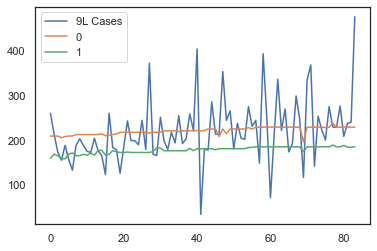

resampling to  M



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
Exogenous Price Columns: ['1', '0']
% of weeks without a purchase: 8.333333333333332


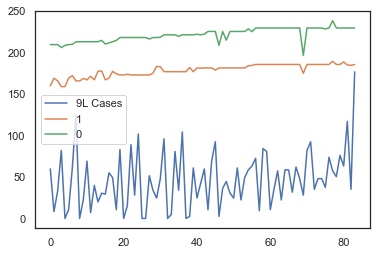

resampling to  M



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
Exogenous Price Columns: ['2', '1']
% of weeks without a purchase: 2.380952380952381


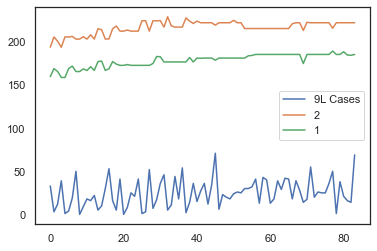

In [10]:
all_data = []

colTime = 'WeekDate'
colPreds = ['9L Cases'] #Demand
colPrice = ['Dollar Sales per 9L Case'] #Price

for i, Product in enumerate(ProductsList):
    # Product = ProductsList[0]
    # colTime = 'WeekDate'
    # colPreds = ['9L Cases'] #Demand
    # colPrice = ['Dollar Sales per 9L Case'] #Price

    #TO DO:
    #Merge top similar only looking at a list of products  DONE
    #Encode before the merge? (same prods same code) DONE
    #one chain, top three products, top 1 similar DONE
    #Impute the price DONE
    (dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw, dfSimilarity
                                                        ,ChainMaster=ChainMaster
                                                        ,Product=Product
                                                        ,ProductsList=ProductsList
                                                        ,topn=TOP_SIMILAR 
                                                        ,periodCol = colTime
                                                        ,resampleFreq=RESAMPLE_FREQ
                                                        ,encodeCols=True)
                                                                            
    
    if i == 0:
        print(f"Decoder: {colDec}")

    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    
    #colExog = colExog + colEndog
    print(f"Exogenous Price Columns: {colExog}")
    
    allCols=[colTime]+colPreds+ colExog
    data=dataModel[allCols]
    print(f"% of weeks without a purchase: {sum(data['9L Cases'] == 0)/data.shape[0]*100}")
    # print(data.tail(5))
    data.iloc[:][data.columns[-(TOP_SIMILAR+2):]].plot()
    all_data.append(data)
    plt.show()




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------


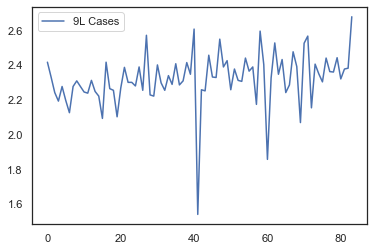




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------


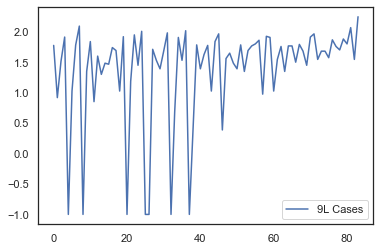




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------


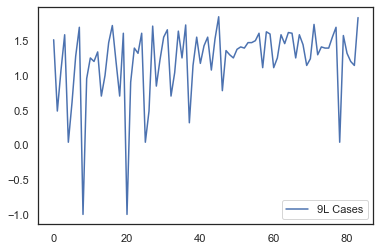

In [11]:
# Input Transformation

all_data_non_transformed =  copy.deepcopy(all_data)
    
if LOG_TRANSFORM: 
    for i in np.arange(len(all_data)):
        all_data_non_transformed[i] = all_data[i].copy(deep=True)
        all_data[i][colPreds] = np.log10(all_data[i][colPreds] + ZERO_ADDER)
        print("\n\n")
        print("-"*50)
        print(f"Product: {colDec.get(str(i))}")
        print("-"*50)
        
        all_data[i].iloc[:][colPreds].plot()
        plt.show()    

In [12]:
# Checks
for i in np.arange(len(all_data)):
    print(i)
    assert((np.log10(all_data_non_transformed[i][colPreds]+ZERO_ADDER) == all_data[i][colPreds]).all().values[0])    

0
1
2


# Test for White Noise

In [13]:
white_noise_all = []
white_noise_df_all = []

for i, data in enumerate(all_data):
    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    white_noise_df = sm.stats.acorr_ljungbox(data[colPreds], lags=[24, 48], return_df=True)
    white_noise_df_all.append(white_noise_df)
    if any(white_noise_df['lb_pvalue'] > 0.05):
        white_noise = True
    else:
        white_noise = False
    white_noise_all.append(white_noise)
    
    print(white_noise_df)
    print(f"\nIs Data White Noise: {white_noise}")





--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
      lb_stat  lb_pvalue
24  26.538512   0.326419
48  48.667832   0.445959

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------
      lb_stat  lb_pvalue
24  41.411630   0.015005
48  54.239869   0.248702

Is Data White Noise: True



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------
      lb_stat  lb_pvalue
24  38.221972    0.03290
48  54.395929    0.24408

Is Data White Noise: True


# Correlation Plots




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------


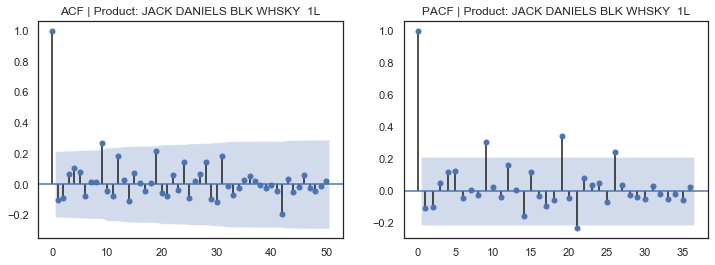

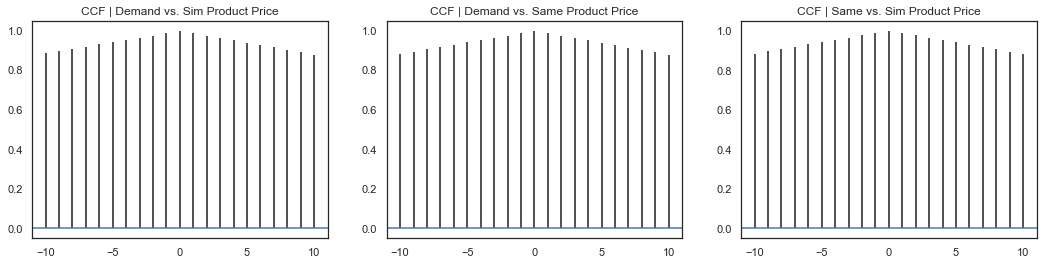

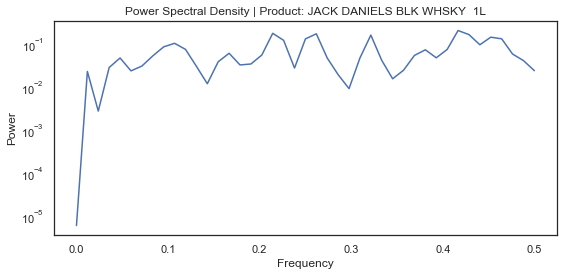




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------


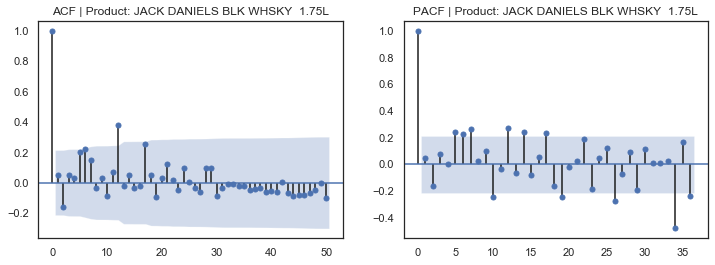

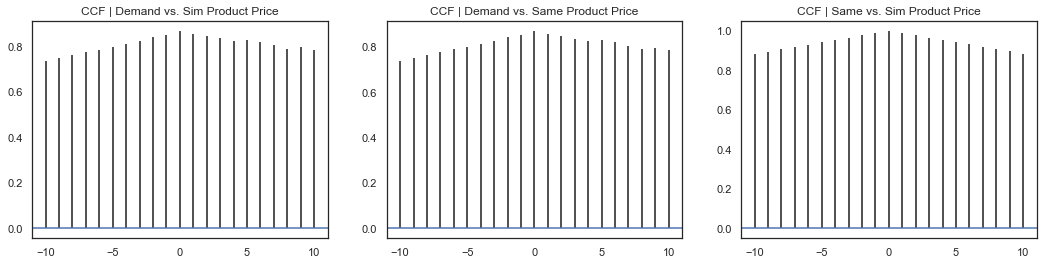

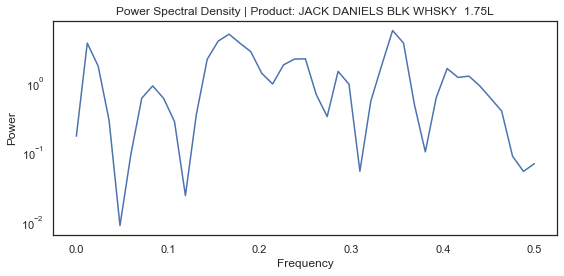




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------


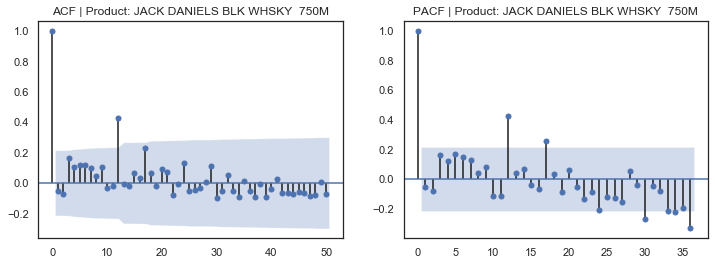

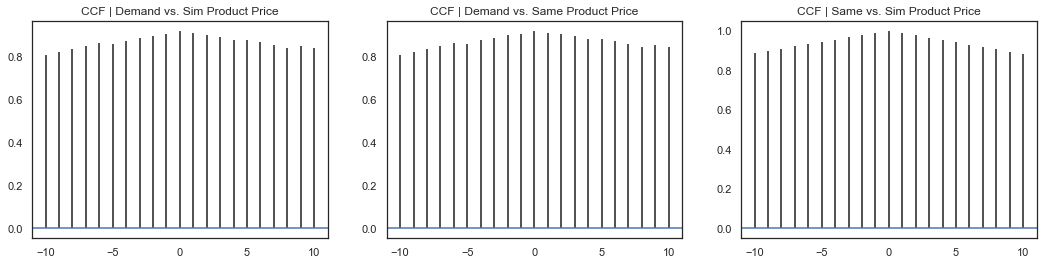

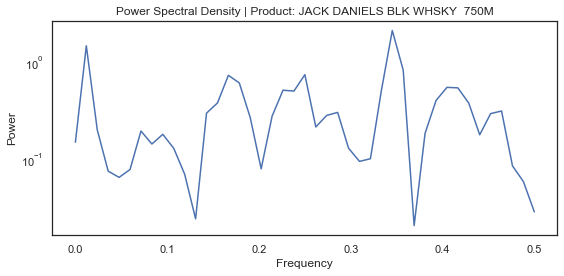

In [69]:
for i, data in enumerate(all_data):
    print("\n\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)

    # ACF and PACF Analysis
    # https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    _ = plot_acf(all_data[i]['9L Cases'], lags=50, ax=axes[0], title=f"ACF | Product: {colDec.get(str(i))}")
    _ = plot_pacf(all_data[i]['9L Cases'], lags=36, ax=axes[1], title=f"PACF | Product: {colDec.get(str(i))}")
    
    # CCF Analysis
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/xcorr_acorr_demo.html#sphx-glr-gallery-lines-bars-and-markers-xcorr-acorr-demo-py
    cols = all_data[i].columns
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    axes[0].xcorr(all_data[i]['9L Cases'], all_data[i][cols[-1]]) # Demand vs. Sim Product Price
    axes[0].set_title('CCF | Demand vs. Sim Product Price')
    axes[1].xcorr(all_data[i]['9L Cases'], all_data[i][cols[-2]]) # Demand vs. Same Product Price
    axes[1].set_title('CCF | Demand vs. Same Product Price')
    axes[2].xcorr(all_data[i][cols[-2]], all_data[i][cols[-1]]) # Same vs. Sim Product Price
    axes[2].set_title('CCF | Same vs. Sim Product Price')

    # Spectral Density
    # https://scipy-lectures.org/intro/scipy/auto_examples/plot_spectrogram.html
    freqs, psd = signal.welch(all_data[i]['9L Cases'])
    plt.figure(figsize=(8, 4))
    plt.semilogy(freqs, psd)
    plt.title(f'Power Spectral Density | Product: {colDec.get(str(i))}')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
      
    
    plt.tight_layout()
    plt.show()

# Model

In [13]:
all_train = []
all_test = []
all_models = []

all_train_non_transformed = []
all_test_non_transformed = []

for i, data in enumerate(all_data):
    train = all_data_non_transformed[i].iloc[:-FORECAST_PERIOD]
    test = all_data_non_transformed[i].iloc[-FORECAST_PERIOD:]
    all_train_non_transformed.append(train)
    all_test_non_transformed.append(test)

    train = data.iloc[:-FORECAST_PERIOD]
    test = data.iloc[-FORECAST_PERIOD:]
    all_train.append(train)
    all_test.append(test)

    print(train.shape,test.shape)

(83, 4) (1, 4)
(83, 4) (1, 4)
(83, 4) (1, 4)


In [14]:
# Checks
for i in np.arange(len(all_data)):
    print(i)
    assert((np.log10(all_train_non_transformed[i][colPreds]+ZERO_ADDER) == all_train[i][colPreds]).all().values[0])
    assert((np.log10(all_test_non_transformed[i][colPreds]+ZERO_ADDER) == all_test[i][colPreds]).all().values[0])

0
1
2


In [15]:
for i, data in enumerate(all_data):
    train = all_train[i]
    test = all_test[i]

    automl_model = AT.AutoTimeSeries(
        score_type='rmse', forecast_period=FORECAST_PERIOD, # time_interval='Week',
        non_seasonal_pdq=None, seasonality=True, seasonal_period=SEASONAL_PERIOD,
        model_type=['SARIMAX', 'auto_SARIMAX', 'ML'],
        verbose=0)
    automl_model.fit(traindata=train, ts_column='WeekDate', target='9L Cases', cv=10, sep=',')
    automl_model.get_leaderboard()
    all_models.append(automl_model)

Start of Fit.....
    Target variable = 9L Cases
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: WeekDate sep: , target: 9L Cases
    Dataframe loaded successfully. Shape of data set = (83, 3)
Time Interval of obserations has not been provided. Program will try to figure this out now...
Time series input in days = 28
It is a Monthly time series.


Building SARIMAX Model



Running Seasonal SARIMAX Model...

Differencing = 0 with Seasonality = False
    Iteration 0 completed...
    Best AR order p = 0, MA order q = 1, Interim metric = -82.181

Differencing = 1 with Seasonality = True
    D = 1 results in an empty ARMA set. Setting Seasonality to False since model might overfit

Differencing = 0 with Seasonality = True
    Iteration 0 completed...
    Best AR order p = 1, MA order q = 0, Interim metric = -61.176

Differencing = 1 with Seasonality = True
    Best AR order p = 0, MA order q = 1, Interim metric = -32.504
Refitting data with prev

In [16]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nLeaderboard")
    print(all_models[i].get_leaderboard())



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Leaderboard
           name      rmse
2            ML  0.039430
1  auto_SARIMAX  0.040814
0       SARIMAX  0.042399


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Leaderboard
           name      rmse
0       SARIMAX  0.131801
2            ML  0.171688
1  auto_SARIMAX  0.192229


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  750M
--------------------------------------------------

Leaderboard
           name      rmse
1  auto_SARIMAX  0.244439
2            ML  0.263912
0       SARIMAX  0.335655


# Visualize Results

In [17]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    cv_scores = all_models[i].get_cv_scores()
    print(cv_scores)   



--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------
           Model  CV Scores
0        SARIMAX   0.034334
1        SARIMAX   0.013804
2        SARIMAX   0.050008
3        SARIMAX   0.080159
4        SARIMAX   0.040803
5        SARIMAX   0.012402
6        SARIMAX   0.081577
7        SARIMAX   0.049988
8        SARIMAX   0.029960
9        SARIMAX   0.030956
10  auto_SARIMAX   0.071569
11  auto_SARIMAX   0.006874
12  auto_SARIMAX   0.047368
13  auto_SARIMAX   0.091769
14  auto_SARIMAX   0.001622
15  auto_SARIMAX   0.007830
16  auto_SARIMAX   0.088653
17  auto_SARIMAX   0.036725
18  auto_SARIMAX   0.046988
19  auto_SARIMAX   0.008739
20            ML   0.043860
21            ML   0.060973
22            ML   0.040863
23            ML   0.056138
24            ML   0.016463
25            ML   0.020437
26            ML   0.067901
27            ML   0.040456
28            ML   0.016602
29            ML   0

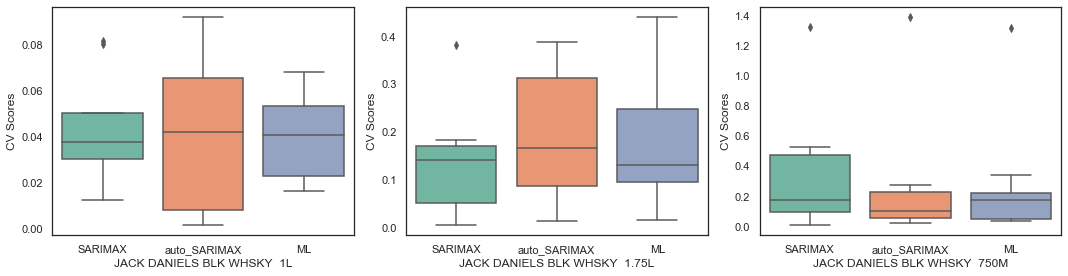

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i in np.arange(len(all_data)):
    ax = all_models[i].plot_cv_scores(ax=axes[i], palette="Set2")
    ax.set(xlabel=colDec.get(str(i)))
plt.tight_layout()

# Prediction

In [19]:
for i in np.arange(len(all_data)):
    print("\n")
    print("-"*50)
    print(f"Product: {colDec.get(str(i))}")
    print("-"*50)
    print("\nTest Data (Original)")
    print(all_test_non_transformed[i])
    print("\nTest Data (Transformed)")
    print(all_test[i])

    #####################
    # temp = all_test[i].set_index('WeekDate')
    # print("Temp")
    # print(temp)

    #####################
    
    test_predictions = all_models[i].predict(X_exogen = all_test[i])
    #test_predictions = all_models[i].predict(X_exogen = temp)
    print("\nBest Prediction (Transformed)")
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nBest Prediction (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)
    
    
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='ML')  
    # test_predictions = all_models[i].predict(X_exogen = temp, model='ML')  
    print("\nML Predictions (Transformed)")
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nML Predictions (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)
    
    print("\nSARIMAX Predictions (Transformed)")
    test_predictions = all_models[i].predict(X_exogen = all_test[i], model='SARIMAX') 
    # test_predictions = all_models[i].predict(X_exogen = temp, model='SARIMAX') 
    print(test_predictions)
    if LOG_TRANSFORM:
        print("\nSARIMAX Predictions (Original)")
        test_predictions = 10**test_predictions
        print(test_predictions)




--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1L
--------------------------------------------------

Test Data (Original)
     WeekDate  9L Cases           0           1
83 2019-12-31    476.14  229.533835  185.589744

Test Data (Transformed)
     WeekDate  9L Cases           0           1
83 2019-12-31  2.677826  229.533835  185.589744

Best Prediction (Transformed)
WeekDate
2019-12-31    2.391658
Name: mean, dtype: float64

Best Prediction (Original)
WeekDate
2019-12-31    246.409752
Name: mean, dtype: float64

ML Predictions (Transformed)
WeekDate
2019-12-31    2.391658
Name: mean, dtype: float64

ML Predictions (Original)
WeekDate
2019-12-31    246.409752
Name: mean, dtype: float64

SARIMAX Predictions (Transformed)
2.3642766976691

SARIMAX Predictions (Original)
231.35383220869852


--------------------------------------------------
Product: JACK DANIELS BLK WHSKY  1.75L
--------------------------------------------------

Test Data (Original

# Optimizer

In [20]:
def complex_objective(x: List, ts_index_name: str, ts_index: List, mask: Optional[List[bool]] = None, verbose: int = 0, return_individual: bool = False, logT = False):
    """
    :param x A list of product pricing for which the revenue has to be computed
    :type x List
    :param mask: If the customer is not going to purchase a product in a period, we can choose to omit it from the revenue calculation in the optimizer.
                 Default = None (considers all products in revenue calculation)
    :type mask  Optional[List[bool]]

    :param ts_index The index to use for the test data. This is needed for some models (such as ML) that use this to create features
    :type ts_index List

    :param return_individual If True, this returns the individual revenue values as well
                             Used mainly when this function is called standalone. Set of False for optimization
    :type return_individual bool

    :param verbose Level of verbosity (Default: 0). This is set to 1 or 2 (mainly for debug purposes)
    :type verbose int
    """

    # Create test data from input
    index = [str(i) for i in np.arange(len(x))]
    x_df = pd.DataFrame(x, index = index)
    x_df = x_df.T

    # Set index (important for some models)
    x_df.index = ts_index
    x_df.index.name = ts_index_name

    # If mask is not provided, use all
    if mask is None:
        mask = [False for item in x] 

    if verbose >= 2:
        print(x_df.info())
        print(x_df.columns)

    total_revenue = 0
    revenue = []

    for i in np.arange(len(all_data)):
        if verbose >= 1:
            print("\n" + "-"*50)
            print(f"Product Index: {i}")
        
        if not mask[i]:
            columns = all_data[i].columns[-(TOP_SIMILAR+1):].values
            if verbose >= 2:
                print(f"All Columns in Test Data: {columns}")

            test_data = x_df[columns]
            prediction = all_models[i].predict(X_exogen = test_data)
            
            if verbose >= 2:
                print(f"Prediction Type: {type(prediction)}")
            if verbose >= 1:
                print(f"Demand Prediction (transformed): {prediction}")

            # If model was created with log transformation
            if logT:
                prediction = 10**prediction
                if verbose >= 1:
                    print("\nDemand Prediction (Original)")
                    print(prediction)
                
            product_revenue = prediction * x[i]

            # TODO: Clamping - Fix later (this gives an error with pandas. We need to pluck it out as a value)
            # product_revenue = max(product_revenue, 0)  # Clamp at min value of 0 for predictions that are negative

            if verbose >= 1:
                print(f"Product Revenue: ${round(product_revenue)}")
                                
            if isinstance(product_revenue, pd.Series):
                product_revenue = product_revenue.iloc[0]
            revenue.append(product_revenue)
                
            # total_revenue = total_revenue + product_revenue
        else:
            if verbose >= 1:
                print("This product's revenue was not included since it was not ordered by the customer in this period.")
            product_revenue = 0
            revenue.append(product_revenue)

        if verbose >= 1:
            print("-"*50 + "\n")
        
    total_revenue = sum(revenue)

    if verbose >= 1:
        print("\n\n" + "="*50)
        print(f"Total Revenue: ${round(total_revenue)}")
        print("="*50 + "\n\n")

    if return_individual is True:
        return -total_revenue, revenue      

    return -total_revenue
    

In [21]:
# Did the customer actually want to but products in that period?
# Only include the revenue in the objective if they actually ordered it
# This model is not trying to predict if they would purchase a product when they were not going to purchase it earlier.
# That requires a lot of human psychology and may not be captured in the model

INCLUDE_MASKING = True

mask: List[bool] = []
for index in np.arange(len(all_data)):
    if INCLUDE_MASKING:
        if all_test[index].iloc[0]['9L Cases'] == 0:
            mask.append(True)
        else:
            mask.append(False)
    else:
        mask.append(False)

print(f"Mask: {mask}")

Mask: [False, False, False]


In [22]:
MARGIN = 0.0 # How much to go over or under the min and max price respectively during the search for optimial revenue
space = []

for index in np.arange(len(all_data)):
    min_val = all_data[index][str(index)].min()
    max_val = all_data[index][str(index)].max()
    min_limit = min_val*(1-MARGIN)
    max_limit = max_val*(1+MARGIN)
    # print(min_val, max_val)
    # print(min_limit, max_limit)
    space.append(Real(low=min_limit, high=max_limit, prior='uniform'))

space

[Real(low=196.51221804511277, high=238.29562345169282, prior='uniform', transform='identity'),
 Real(low=158.86324786324786, high=189.49694749694748, prior='uniform', transform='identity'),
 Real(low=193.91, high=229.32, prior='uniform', transform='identity')]

In [23]:
test_index_name = 'WeekDate'
print(test_index_name)
test_index = all_test_non_transformed[0][test_index_name].values
print(test_index)

WeekDate
['2019-12-31T00:00:00.000000000']


In [24]:
# create a new function with mask
masked_complex_objective = partial(complex_objective, ts_index_name=test_index_name, ts_index=test_index, mask=mask, logT=LOG_TRANSFORM)
print(f"Revenue without masking: ${-round(complex_objective([266.51, 195.06, 205.3], ts_index_name=test_index_name, ts_index=test_index, logT=LOG_TRANSFORM))}")
print(f"Revenue with masking: ${-round(masked_complex_objective([266.51, 195.06, 205.3]))}")

Revenue without masking: $103194
Revenue with masking: $103194


In [25]:
res = gp_minimize(masked_complex_objective,   
                  space,                      
                  acq_func="EI",              
                  n_calls=200,                
                  n_random_starts=20,  
                  random_state=42)     

In [26]:
print(f"Optimal Price for All Products ($): {[round(price, 2) for price in res.x]} \nMaximum Revenue Expected: ${round(-res.fun)}")
_, all_revenue = masked_complex_objective(res.x, return_individual=True)
print(f"Individual Optimized Revenue: {all_revenue}")

Optimal Price for All Products ($): [201.53, 188.47, 197.52] 
Maximum Revenue Expected: $120144
Individual Optimized Revenue: [49658.26827017341, 33096.75098167411, 37389.347820166695]


In [27]:
# 3. Reserve a test set - compute revenue from test set and compare to the one from the optimizer
# This is only for the 1st entry in the test set

total_test_data_revenue = 0
for index in np.arange(len(all_data)):
    product_price = all_test_non_transformed[index].iloc[0][str(index)]
    product_demand = all_test_non_transformed[index].iloc[0]['9L Cases']
    product_revenue = product_price * product_demand
    print(f"Product {index} Price 9L Case: ${round(product_price,2)} Revenue: ${round(product_revenue)}")
    total_test_data_revenue = total_test_data_revenue + product_revenue
    
print(f"Total Revenue: ${round(total_test_data_revenue)}")

# Also, some things dont make sense.
# The models are grosely underestimating the demand (as can be seen by the predictions above)

Product 0 Price 9L Case: $229.53 Revenue: $109290
Product 1 Price 9L Case: $185.59 Revenue: $32788
Product 2 Price 9L Case: $222.36 Revenue: $15343
Total Revenue: $157421


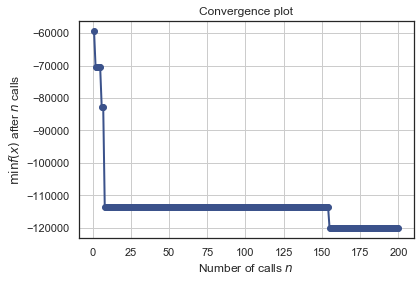

In [28]:
plot_convergence(res)

# TODO

1. Build a baseline model for all products (maybe average of last 2 years (same period) and Compare the performance of automl models to baseline models
2. Compute revenue expected with baseline models and compare to the one from the optimizer
3. [DONE] Reserve a test set - compute revenue from test set and compare to the one from the optimizer
6. Consider taking more "similar" products into consideration

In [29]:
math.ceil(space[0].low)
math.floor(space[0].high)
xs = np.arange(math.ceil(space[0].low), math.floor(space[0].high), step=5)
ys = np.arange(math.ceil(space[1].low), math.floor(space[1].high), step=5)

print(xs)
print(ys)

[197 202 207 212 217 222 227 232 237]
[159 164 169 174 179 184]


In [30]:
"".join(ProdCat.split())

'SUPPREMWHISKEY'

In [31]:
filename = "".join(ChainMaster.split()) + "_" + "".join(ProdCat.split()) + "_Top" + str(TOP_PRODUCTS) + "_Sim" + str(TOP_SIMILAR) + \
        "_Log" + str(LOG_TRANSFORM) + "_Add" + str(ZERO_ADDER) + \
        "_Prod" + str(i) + "_Resample" + str(RESAMPLE_FREQ) + "_f" + str(FORECAST_PERIOD) + "_s" + str(SEASONAL_PERIOD) + ".html"
filename

'SPECS_SUPPREMWHISKEY_Top3_Sim1_LogTrue_Add0.1_Prod2_ResampleM_f1_s12.html'

In [32]:
verbose =  1
STEPS = 5

allp = [np.arange(math.ceil(space[i].low), math.floor(space[i].high), step=STEPS) for i in np.arange(len(all_data))] 

if verbose >= 1:
    print("-"*100)
    print(f"Price intervals for product 0: {allp[0]}")
    print(f"Price intervals for product 1: {allp[1]}")
    print(f"Price intervals for product 2: {allp[2]}")
    print("-"*100, "\n")

for i in np.arange(len(all_data)):
    print("\n\n")
    mask_plot = [False if i == j else True for j in np.arange(len(all_data))]
    if verbose >= 1:
        print(f"Product {i} --> Mask: {mask_plot}")

    columns = all_data[i].columns[-(TOP_SIMILAR+1):].values
    if verbose >= 1:
        print(f"Products used in Model: {columns}")
        
    masked_complex_objective_plot = partial(complex_objective, ts_index_name=test_index_name, ts_index=test_index, mask=mask_plot, logT=LOG_TRANSFORM, verbose=0)

    finalx = []
    finaly = []
    finalrev = []

    xs = allp[int(columns[0])]  # Main Product Price is in xs
    ys = allp[int(columns[1])]  # Exogenous Product Price in in ys

    if verbose >= 1:
        print(f"Price intervals used for X-axis (product {int(columns[0])}): {xs}")
        print(f"Price intervals used for Y-axis (product {int(columns[1])}): {ys}")
        
    for x, y in itertools.product(xs, ys):
        price_list = [0, 0, 0]
        
        # Fix price for product 0
        if int(columns[0]) == 0:  # If the main product is product 0
            price_list[0] = x
        elif int(columns[1]) == 0: # If exogenous product is product 0
            price_list[0] = y
        else:
            price_list[0] = 0

        # Fix price for product 1
        if int(columns[0]) == 1:  # If the main product is product 1
            price_list[1] = x
        elif int(columns[1]) == 1: # If exogenous product is product 1
            price_list[1] = y
        else:
            price_list[1] = 0

        # Fix price for product 2
        if int(columns[0]) == 2:  # If the main product is product 2
            price_list[2] = x
        elif int(columns[1]) == 2: # If exogenous product is product 2
            price_list[2] = y
        else:
            price_list[2] = 0
       
        rev = -masked_complex_objective_plot(price_list)
        finalx.append(x)
        finaly.append(y)
        finalrev.append(rev)   

    fig = surface3DChart(
        x=finalx, y=finaly, z=finalrev,
        title= 'Product ' + columns[0] + ' Revenue',
        xTitle= 'Product ' + columns[0] + ' Price',
        yTitle= 'Product ' + columns[1] + ' Price',
        width=1200,
        height=800            
        )

    filename = "".join(ChainMaster.split()) + "_" + "".join(ProdCat.split()) + "_Top" + str(TOP_PRODUCTS) + "_Sim" + str(TOP_SIMILAR) + \
        "_Log" + str(LOG_TRANSFORM) + "_Add" + str(ZERO_ADDER) + \
        "_Prod" + str(i) + "_Resample" + str(RESAMPLE_FREQ) + "_f" + str(FORECAST_PERIOD) + "_s" + str(SEASONAL_PERIOD) + ".html"
    py.plot(fig, filename = filename)


----------------------------------------------------------------------------------------------------
Price intervals for product 0: [197 202 207 212 217 222 227 232 237]
Price intervals for product 1: [159 164 169 174 179 184]
Price intervals for product 2: [194 199 204 209 214 219 224]
---------------------------------------------------------------------------------------------------- 




Product 0 --> Mask: [False, True, True]
Products used in Model: ['0' '1']
Price intervals used for X-axis (product 0): [197 202 207 212 217 222 227 232 237]
Price intervals used for Y-axis (product 1): [159 164 169 174 179 184]



Product 1 --> Mask: [True, False, True]
Products used in Model: ['1' '0']
Price intervals used for X-axis (product 1): [159 164 169 174 179 184]
Price intervals used for Y-axis (product 0): [197 202 207 212 217 222 227 232 237]



Product 2 --> Mask: [True, True, False]
Products used in Model: ['2' '1']
Price intervals used for X-axis (product 2): [194 199 204 209 214 219 